# 27 III 2025

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import toolkit
import pickle

In [2]:
with open("data/train.pkl", "rb") as file:
    X_train = pickle.load(file).reset_index()

In [3]:
toolkit.replace(X_train)

index  Status                                            Message
0        973       2  From OWNER-NOLIST-SGODAILY*JM**NETNOTEINC*-COM...
1       4592       0  Return-Path: skip@pobox.com .Delivery-Date: Sa...
2      13730       0  From ilug-admin@linux.ie  Fri Jul 19 23:44:22 ...
3       3046       2  From travelincentives@aol.com  Mon Aug  6 20:0...
4       6790       0  From rpm-list-admin@freshrpms.net  Wed Jul 31 ...
...      ...     ...                                                ...
17411  13802       0  From ilug-admin@linux.ie  Tue Jul 30 10:11:31 ...
17412   8665       0  Return-Path: guido@python.org .Delivery-Date: ...
17413   7894       0  From fork-admin@xent.com  Sat Oct  5 17:22:20 ...
17414   3908       0  From exmh-users-admin@redhat.com  Mon Sep 16 1...
17415    626       0  From fork-admin@xent.com  Thu Sep 12 13:39:57 ...

[17416 rows x 3 columns]

In [4]:
X_train.loc[1, "Message"]

'Return-Path: skip@pobox.com .Delivery-Date: Sat Sep  7 05:05:45 2002 .From: skip@pobox.com (Skip Montanaro) .Date: Fri  6 Sep 2002 23:05:45 -0500 .Subject: [Spambayes] Maybe change X-Spam-Disposition to something else... .Message-ID: <15737.31513.555967.915801@12-248-11-90.client.attbi.com> . . .I actually like Neale\'s X-Spam-Disposition header  I just wonder if maybe we .should choose something with a different prefix than "X-Spam-" so that .people don\'t confuse it with SpamAssassin  all of whose headers begin with .that prefix. . .Also  some sort of version information would be useful.  Perhaps the CVS .version number for the classifier module could be tacked on. . .Skip '

In [5]:
X_train_spam = X_train[X_train["Status"] == 2]
X_train_ham = X_train[X_train["Status"]  < 2]

In [6]:
spam_words = dict()
ham_words = dict()
counter_spam = 0
for index, row in X_train_spam.iterrows():
    #print(row)
    x = pd.Series(row["Message"].split(" "))
    x = x[x != ""]
    x = x.value_counts()
    for (word, count) in x.to_dict().items():
        if word in spam_words.keys():
            spam_words[word] = spam_words[word] + count
        else:
            spam_words[word] = count

    counter_spam += 1

In [7]:
counter_ham = 0
for index, row in X_train_ham.iterrows():
    #print(row)
    x = pd.Series(row["Message"].split(" "))
    x = x[x != ""]
    x = x.value_counts()
    for (word, count) in x.to_dict().items():
        if word in ham_words.keys():
            ham_words[word] = ham_words[word] + count
        else:
            ham_words[word] = count

    counter_ham += 1

In [11]:
ham_words["total_count"]

KeyError: 'total_count'

In [12]:
spam_words["total_count"]

KeyError: 'total_count'

In [20]:
ham_words["total_count"] = counter_ham
spam_words["total_count"] = counter_spam

In [21]:
with open("ham_training_word_dictionary.pkl", "wb") as file:
    pickle.dump(ham_words, file)

In [22]:
with open("spam_training_word_dictionary.pkl", "wb") as file:
    pickle.dump(spam_words, file)

## Analysis

In [23]:
ham_words = pd.Series(ham_words)
spam_words = pd.Series(spam_words)

In [24]:
threshold = 0.1
ham_words = ham_words[ham_words > threshold*counter_ham]
spam_words = spam_words[spam_words > threshold*counter_spam]

In [25]:
ham_words.sort_values(ascending=False)[:20]/counter_ham

.             30.120977
the            9.549897
2002           8.633378
with           6.738781
from           6.648657
to             6.632492
.>             6.387216
.Received:     5.784691
of             5.153676
a              4.947446
for            4.840936
and            4.718556
by             4.585105
id             4.295689
ESMTP            3.2655
+0100          3.092634
in             3.092265
is             2.976971
Aug            2.899911
Sep            2.660097
dtype: object

In [26]:
spam_words.sort_values(ascending=False)[:20]/counter_spam

.             47.252327
the            8.473888
to             8.302482
2002           6.449586
and            6.314116
with           5.756463
from           5.667011
of             5.607549
you            4.868666
for            4.770165
=              4.343588
.Received:     4.318511
a              4.282834
by             3.512927
your           3.309979
in             3.295243
id             3.209152
is             3.016805
<td            2.515512
this           2.214581
dtype: object

In [27]:
ham_words.name = "count_ham"
spam_words.name = "count_spam"

In [28]:
ham_words = ham_words / counter_ham
spam_words = spam_words / counter_spam

In [29]:
comparison = pd.DataFrame(ham_words).reset_index(names="word")\
.merge(pd.DataFrame(spam_words).reset_index(names="word"), on="word")

In [30]:
comparison.head()

word  count_ham count_spam
0     .  30.120977  47.252327
1  with   6.738781   5.756463
2   Sep   2.660097   1.494054
3  2002   8.633378   6.449586
4    be   1.610127   1.868149

In [31]:
comparison.shape

(312, 3)

In [32]:
higher_in_ham = comparison.loc[
        comparison["count_ham"] > comparison["count_spam"],
        "word"
]

In [33]:
higher_in_spam = comparison.loc[
        comparison["count_ham"] < comparison["count_spam"],
        "word"
]

In [34]:
higher_in_ham.shape, higher_in_spam.shape

((164,), (147,))

In [35]:
comparison.sort_values("count_ham", ascending=False)

word  count_ham count_spam
0         .  30.120977  47.252327
5       the   9.549897   8.473888
3      2002   8.633378   6.449586
1      with   6.738781   5.756463
39     from   6.648657   5.667011
..      ...        ...        ...
251    down   0.101565     0.1091
258  please   0.101343   0.444157
180    each   0.101343   0.195708
186      14   0.100384   0.100052
265  e-mail   0.100236   0.310238

[312 rows x 3 columns]

In [36]:
comparison[(comparison["count_ham"] > 1) | (comparison["count_spam"] > 1)].sort_values("count_ham", ascending=False).reset_index(drop=True)

word  count_ham count_spam
0           .  30.120977  47.252327
1         the   9.549897   8.473888
2        2002   8.633378   6.449586
3        with   6.738781   5.756463
4        from   6.648657   5.667011
..        ...        ...        ...
60       will   0.634632    1.51241
61        <td   0.333481   2.515512
62        our   0.306244   1.364529
63  Helvetica   0.164969    1.60393
64      </tr>   0.108355   1.749224

[65 rows x 3 columns]

In [41]:
frequent = comparison[(comparison["count_ham"] > 1) | (comparison["count_spam"] > 1)].sort_values("count_ham", ascending=False).reset_index(drop=True)

In [43]:
frequent[frequent["word"] == "Fri"], frequent[frequent["word"] == "Mon"]

(   word count_ham count_spam
 47  Fri   1.11116   0.787487,
    word count_ham count_spam
 31  Mon  1.535872   1.372802)

In [48]:
frequent[frequent["word"] == "Wed"]

word count_ham count_spam
32  Wed  1.516239   0.945708

In [49]:
list(frequent["word"])

['.',
 'the',
 '2002',
 'with',
 'from',
 'to',
 '.>',
 '.Received:',
 'of',
 'a',
 'for',
 'and',
 'by',
 'id',
 'ESMTP',
 '+0100',
 'in',
 'is',
 'Aug',
 'Sep',
 'that',
 'I',
 'localhost',
 '.\tby',
 '.\tfor',
 '[127.0.0.1])',
 'it',
 'on',
 '(Postfix)',
 '>',
 'be',
 'Mon',
 'Wed',
 '(IST)',
 'you',
 'Thu',
 'Tue',
 '.Delivered-To:',
 'this',
 '(8.11.6/8.11.6)',
 '-0400',
 '-0700',
 'dogma.slashnull.org',
 'Jul',
 '.Date:',
 'have',
 'are',
 'Fri',
 'as',
 '.From:',
 '(localhost',
 '.Subject:',
 '.To:',
 'not',
 '.Content-Type:',
 'or',
 '-',
 'your',
 '=',
 'can',
 'will',
 '<td',
 'our',
 'Helvetica',
 '</tr>']

### Examining words frequent in spam and absent in ham

In [52]:
df = pd.DataFrame(spam_words).reset_index(names="word").merge(pd.DataFrame(ham_words).reset_index(names="word"), how="left")

In [53]:
df = df[df["count_ham"].isna()].drop("count_ham", axis=1)

In [55]:
df.sort_values("count_spam", ascending=False)

word count_spam
599            ;    1.93304
420  sans-serif"   0.982678
5          </td>     0.9788
567        Arial   0.925801
8           <tr>   0.833506
..           ...        ...
399        great   0.101086
609       &nbsp;   0.101086
383      account   0.101086
499           PM   0.101086
616    .<b><font   0.100827

[317 rows x 2 columns]

In [60]:
spam_words_df = pd.DataFrame(spam_words).reset_index(names="word")

In [72]:
spam_words_ = spam_words_df[(spam_words_df["word"].str.find(">")>0) | (spam_words_df["word"].str.find("<")>0)]

In [73]:
spam_words_.shape

(70, 2)

In [74]:
spam_words_['count_spam'].sum()

19.55299896587383

In [75]:
ham_words_df = pd.DataFrame(ham_words).reset_index(names="word")

In [76]:
ham_words_df_ = ham_words_df[(ham_words_df["word"].str.find(">")>0) | (ham_words_df["word"].str.find("<")>0) ]

In [77]:
ham_words_df_.shape

(42, 2)

In [78]:
ham_words_df_['count_ham'].sum()

16.08480956598761

Na szczególną uwagę zasługują także < oraz >

In [79]:
df = ham_words_df.merge(spam_words_df, how="left")

In [80]:
df = df[df['count_spam'].isna()]

In [82]:
df.sort_values("count_ham", ascending=False)

word count_ham count_spam
204                                                Oct  1.436227        NaN
352                                                .\t  0.810378        NaN
188                                 .List-Unsubscribe:  0.596177        NaN
190                                   .List-Subscribe:  0.564511        NaN
184                                        .List-Help:  0.558016        NaN
..                                                 ...       ...        ...
292                                               user  0.102081        NaN
427                                            running  0.101786        NaN
530  .iIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIi...  0.100974        NaN
360                                                 So  0.100827        NaN
390                                               case  0.100384        NaN

[221 rows x 3 columns]

There's nothing special about words present in one category and absent in the other, so we'll focus on the words present in both of them. Let's plot some histograms to reveale distributions.

## Distributions of words' counts

In [83]:
comparison.head()

word  count_ham count_spam
0     .  30.120977  47.252327
1  with   6.738781   5.756463
2   Sep   2.660097   1.494054
3  2002   8.633378   6.449586
4    be   1.610127   1.868149

In [84]:
comparison.shape

(312, 3)

In [87]:
df = comparison[["word"]]

In [88]:
df["count"] = 0

C:\Users\User\AppData\Local\Temp\ipykernel_17424\1395553266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["count"] = 0


In [89]:
df

word  count
0              .      0
1           with      0
2            Sep      0
3           2002      0
4             be      0
..           ...    ...
307           17      0
308           18      0
309          <TD      0
310          .mv      0
311  total_count      0

[312 rows x 2 columns]

In [92]:
statring_dict = df.set_index("word").to_dict()

In [93]:
ham_series = []

for index, row in X_train_ham.iterrows():
    x = pd.Series(row["Message"].split(" "))
    x = x[x != ""]
    ham_series.append(x.value_counts())

In [110]:
for i in range(len(ham_series)):
    ham_series[i].name = str(i+1)
    ham_series[i] = pd.DataFrame(ham_series[i]).reset_index(names="word")

In [112]:
df.drop("count", inplace=True, axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_17424\3550670779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("count", inplace=True, axis=1)


In [114]:
df.merge(ham_series[0], how="left")

word    1
0              .  4.0
1           with  3.0
2            Sep  2.0
3           2002  2.0
4             be  2.0
..           ...  ...
307           17  NaN
308           18  NaN
309          <TD  NaN
310          .mv  NaN
311  total_count  NaN

[312 rows x 2 columns]

In [117]:
df_ = df
for series in ham_series:
    df_ = df_.merge(series, how="left", on="word")

In [118]:
df_.shape

(312, 13549)

In [119]:
X_train_ham.shape

(13548, 3)

In [126]:
df_ = df_.set_index("word").T

In [127]:
df_.shape

(13548, 312)

In [128]:
with open("ham_important_words_df.pkl", "wb") as file:
    pickle.dump(df_, file)

In [129]:
del ham_series, ham_series_

In [130]:
spam_series = []

for index, row in X_train_spam.iterrows():
    x = pd.Series(row["Message"].split(" "))
    x = x[x != ""]
    spam_series.append(x.value_counts())

In [132]:
for i in range(len(spam_series)):
    spam_series[i].name = str(i+1)
    spam_series[i] = pd.DataFrame(spam_series[i]).reset_index(names="word")

In [133]:
df_ = df
for series in spam_series:
    df_ = df_.merge(series, how="left", on="word")

In [138]:
with open("spam_important_words_df.pkl", "wb") as file:
    pickle.dump(df_.set_index("word").T, file)

In [139]:
with open("spam_important_words_df.pkl", "rb") as file:
    z = pickle.load(file)

In [140]:
z.shape

(3868, 312)

In [141]:
with open("ham_important_words_df.pkl", "rb") as file:
    z = pickle.load(file)
z.shape

(13548, 312)

# 28 III 2025

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import toolkit

In [2]:
with open("spam_important_words_df.pkl", "rb") as file:
    spam_words_count = pickle.load(file)

In [3]:
with open("ham_important_words_df.pkl", "rb") as file:
    ham_words_count = pickle.load(file)

In [4]:
spam_words_count.shape, ham_words_cont.shape

((3868, 312), (13548, 312))

In [8]:
spam_words_count = spam_words_count.fillna(0)
ham_words_count = ham_words_count.fillna(0)

In [12]:
important_words = list(ham_words_count.columns)

In [53]:
i = 0
counter=0
plt.figure(figsize=(10, 30*40))
for word in important_words:
    counter += 1
    plt.subplot(len(important_words), 2, counter)
    x = spam_words_count[word].sort_values(ascending=True)
    x = x[:int(0.95*x.shape[0])]
    sns.histplot(x, color="red", stat="probability")
    plt.title(f"Spam Histogram of word '{word}'")
    plt.xlabel("")

    counter += 1
    plt.subplot(len(important_words), 2, counter)
    x = ham_words_count[word].sort_values(ascending=True)
    x = x[:int(0.95*x.shape[0])]
    sns.histplot(x, color="green", stat="probability")
    plt.title(f"Ham Histogram of word '{word}'")
    plt.xlabel("")

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


In some chart x_scale was inappropiate, let's plot them again:

Text(0.5, 0, '')

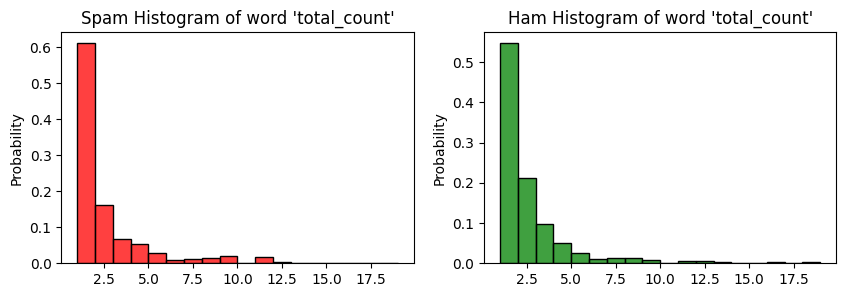

In [45]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
sns.histplot(spam_words_count["was"], color="red", stat="probability", bins=np.arange(1, 20))
plt.title(f"Spam Histogram of word '{word}'")
plt.xlabel("")

plt.subplot(1, 2, 2)
sns.histplot(ham_words_count["was"], color="green", stat="probability", bins=np.arange(1, 20))
plt.title(f"Ham Histogram of word '{word}'")
plt.xlabel("")

Text(0.5, 0, '')

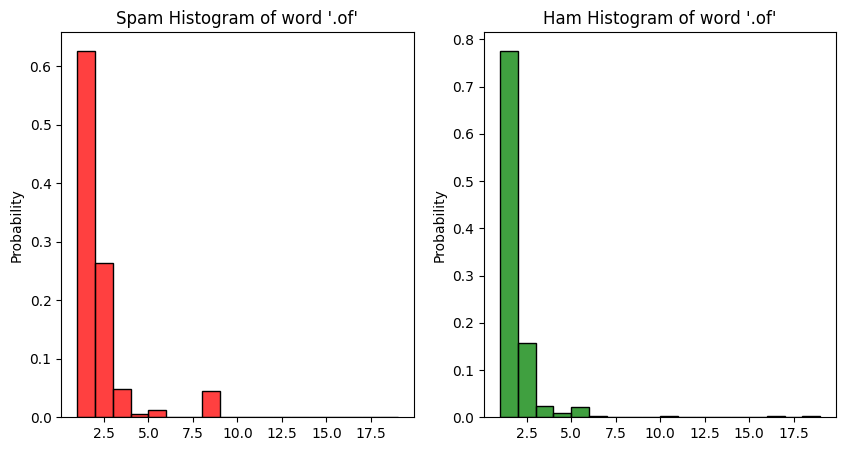

In [46]:
plt.figure(figsize=(10, 5))

word = ".of"

plt.subplot(1, 2, 1)
sns.histplot(spam_words_count[word], color="red", stat="probability", bins=np.arange(1, 20))
plt.title(f"Spam Histogram of word '{word}'")
plt.xlabel("")

plt.subplot(1, 2, 2)
sns.histplot(ham_words_count[word], color="green", stat="probability", bins=np.arange(1, 20))
plt.title(f"Ham Histogram of word '{word}'")
plt.xlabel("")

Text(0.5, 0, '')

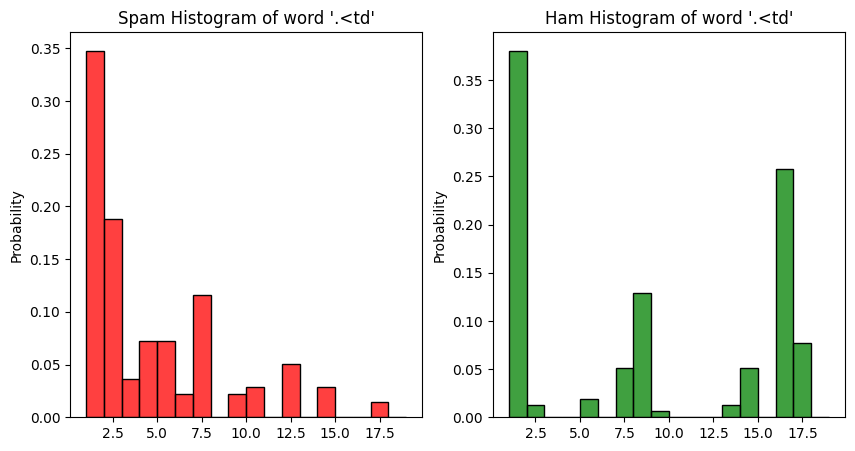

In [47]:
plt.figure(figsize=(10, 5))

word = ".<td"

plt.subplot(1, 2, 1)
sns.histplot(spam_words_count[word], color="red", stat="probability", bins=np.arange(1, 20))
plt.title(f"Spam Histogram of word '{word}'")
plt.xlabel("")

plt.subplot(1, 2, 2)
sns.histplot(ham_words_count[word], color="green", stat="probability", bins=np.arange(1, 20))
plt.title(f"Ham Histogram of word '{word}'")
plt.xlabel("")

Text(0.5, 0, '')

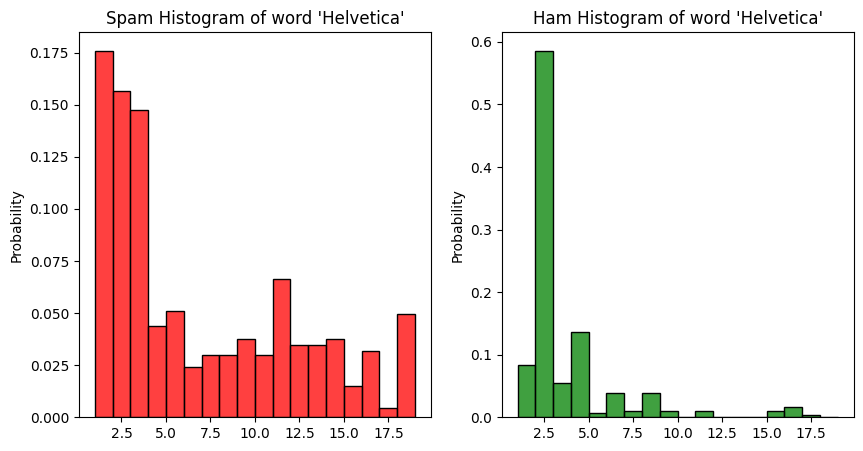

In [48]:
plt.figure(figsize=(10, 5))

word = "Helvetica"

plt.subplot(1, 2, 1)
sns.histplot(spam_words_count[word], color="red", stat="probability", bins=np.arange(1, 20))
plt.title(f"Spam Histogram of word '{word}'")
plt.xlabel("")

plt.subplot(1, 2, 2)
sns.histplot(ham_words_count[word], color="green", stat="probability", bins=np.arange(1, 20))
plt.title(f"Ham Histogram of word '{word}'")
plt.xlabel("")

Text(0.5, 0, '')

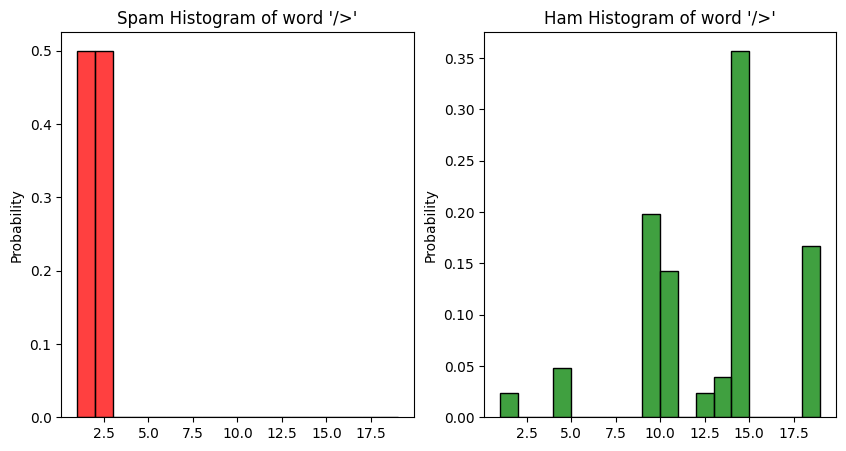

In [49]:
plt.figure(figsize=(10, 5))

word = "/>"

plt.subplot(1, 2, 1)
sns.histplot(spam_words_count[word], color="red", stat="probability", bins=np.arange(1, 20))
plt.title(f"Spam Histogram of word '{word}'")
plt.xlabel("")

plt.subplot(1, 2, 2)
sns.histplot(ham_words_count[word], color="green", stat="probability", bins=np.arange(1, 20))
plt.title(f"Ham Histogram of word '{word}'")
plt.xlabel("")

Text(0.5, 0, '')

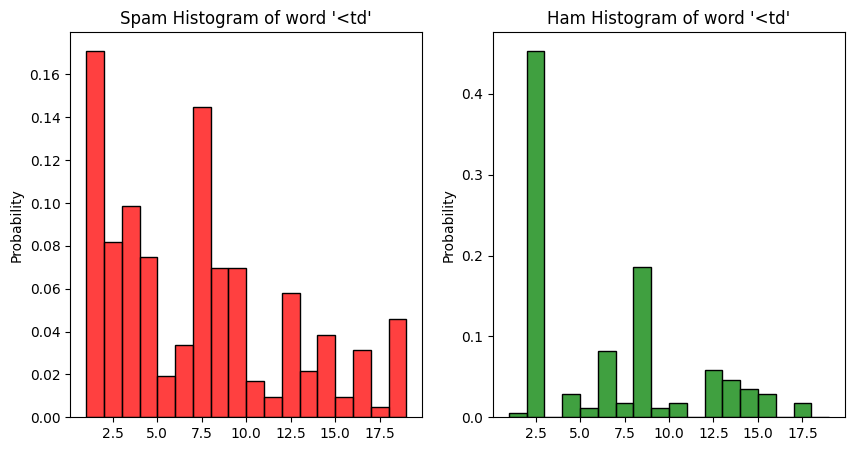

In [50]:
plt.figure(figsize=(10, 5))

word = "<td"

plt.subplot(1, 2, 1)
sns.histplot(spam_words_count[word], color="red", stat="probability", bins=np.arange(1, 20))
plt.title(f"Spam Histogram of word '{word}'")
plt.xlabel("")

plt.subplot(1, 2, 2)
sns.histplot(ham_words_count[word], color="green", stat="probability", bins=np.arange(1, 20))
plt.title(f"Ham Histogram of word '{word}'")
plt.xlabel("")

we can tell, there's no huge difference between spam and ham, lets focus on word's where difference can be noticed

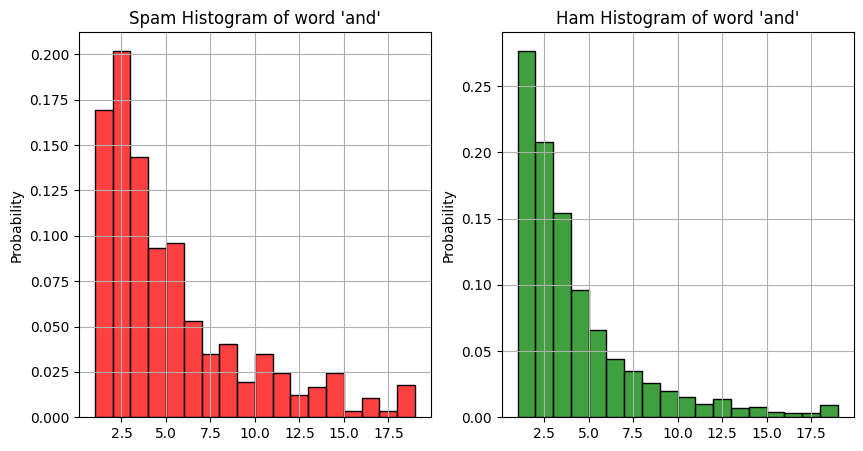

In [51]:
plt.figure(figsize=(10, 5))

word = "and"


plt.subplot(1, 2, 1)
sns.histplot(spam_words_count[word], color="red", stat="probability", bins=np.arange(1, 20))
plt.title(f"Spam Histogram of word '{word}'")
plt.xlabel("")
plt.grid("on")


plt.subplot(1, 2, 2)
sns.histplot(ham_words_count[word], color="green", stat="probability", bins=np.arange(1, 20))
plt.title(f"Ham Histogram of word '{word}'")
plt.xlabel("")
plt.grid("on")


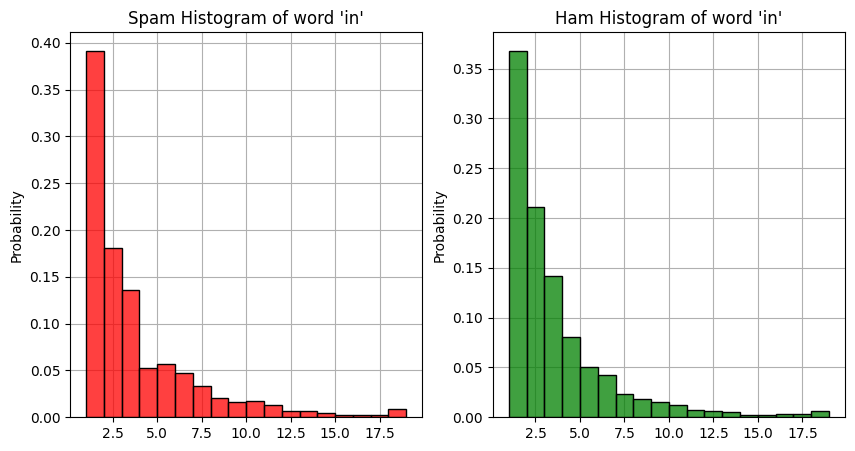

In [43]:
plt.figure(figsize=(10, 5))

word = "in"


plt.subplot(1, 2, 1)
sns.histplot(spam_words_count[word], color="red", stat="probability", bins=np.arange(1, 20), zorder=20)
plt.title(f"Spam Histogram of word '{word}'")
plt.xlabel("")
plt.grid("on", zorder=1)


plt.subplot(1, 2, 2)
sns.histplot(ham_words_count[word], color="green", stat="probability", bins=np.arange(1, 20), zorder=20)
plt.title(f"Ham Histogram of word '{word}'")
plt.xlabel("")
plt.grid("on", zorder=1)


Still, there's no signifficant difference, let's have our last try on number of words cointaining "<" or ">"

In [91]:
s = "., with, 2002, the, of, -0500, to, I, a, that, it, .>, is, +0100, .Received:, ESMTP, id, by, Linux, and, .Content-Type:, .Sender:, .Errors-To:, .X-Mailman-Version:, .Precedence:, bulk, .List-Id:, .X-Beenthere:, (Postfix), using, .Delivered-To:, or, <jm@localhost>;, -0400, IMAP, (fetchmail-5.9.0), jm@localhost, (single-drop);, (IST), you, (PDT), -0700, [127.0.0.1], SMTP, (jalapeno, in, .Content-Transfer-Encoding:, will, your, email, Microsoft, its, >, our, want, <a, .<font,"

In [92]:
s=s.replace(" ", "").split(",")
s = [w for w in s if w]

In [93]:
len(s)

57

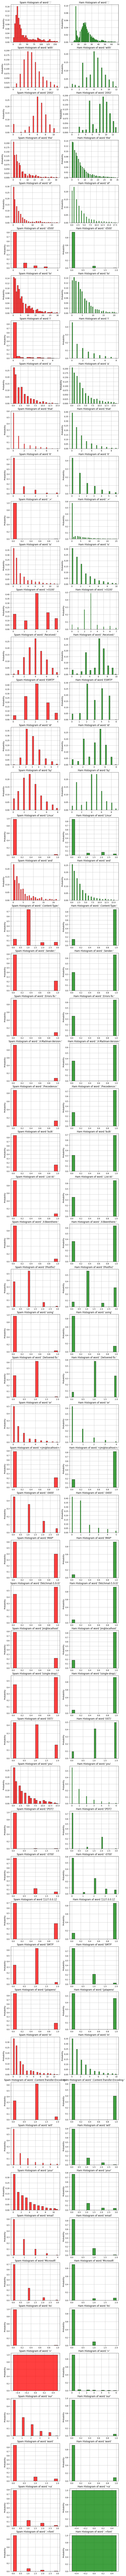

In [97]:
i = 0
counter=0
plt.figure(figsize=(10, 6*40))
for word in s:
    counter += 1
    plt.subplot(len(s), 2, counter)
    x = spam_words_count[word].sort_values(ascending=True)
    x = x[:int(0.95*x.shape[0])]
    sns.histplot(x, color="red", stat="probability", zorder=2)
    plt.title(f"Spam Histogram of word '{word}'")
    plt.xlabel("")
    plt.grid("on", zorder=1)

    counter += 1
    plt.subplot(len(s), 2, counter)
    x = ham_words_count[word].sort_values(ascending=True)
    x = x[:int(0.95*x.shape[0])]
    sns.histplot(x, color="green", stat="probability", zorder=2)
    plt.title(f"Ham Histogram of word '{word}'")
    plt.xlabel("")
    plt.grid("on", zorder=1)

In [76]:
counter

55

In [61]:
word

'.Content-Type'

In [85]:
[s for s in important_words if "fetch" in s]

['(fetchmail-5.9.0)']

In [99]:
[c for c in ham_words_count.columns if "by" in c.lower()]

['by', '.\tby', 'By']

In [101]:
[c for c in ham_words_count.columns if c.lower().endswith("for")]

['for', '.\tfor', 'For']

In [102]:
x_ham = ham_words_count.loc[:, [c for c in ham_words_count.columns if "by" in c.lower()]]

In [103]:
x_spam = spam_words_count.loc[:, [c for c in ham_words_count.columns if "by" in c.lower()]]

In [114]:
x_ham.to_numpy().sum(axis=1)

array([ 0.,  7.,  6., ..., 23.,  9., 20.])

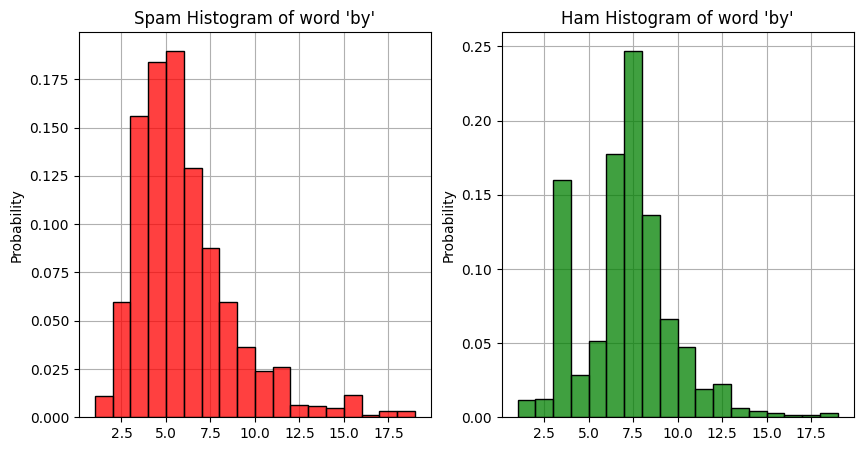

In [116]:
plt.figure(figsize=(10, 5))

word = "by"


plt.subplot(1, 2, 1)
sns.histplot(x_spam.to_numpy().sum(axis=1), color="red", stat="probability", bins=np.arange(1, 20), zorder=20)
plt.title(f"Spam Histogram of word '{word}'")
plt.xlabel("")
plt.grid("on", zorder=1)


plt.subplot(1, 2, 2)
sns.histplot(x_ham.to_numpy().sum(axis=1), color="green", stat="probability", bins=np.arange(1, 20), zorder=20)
plt.title(f"Ham Histogram of word '{word}'")
plt.xlabel("")
plt.grid("on", zorder=1)


In [117]:
x_ham = ham_words_count.loc[:, [c for c in ham_words_count.columns if c.lower().endswith("for")]]
x_spam = spam_words_count.loc[:, [c for c in ham_words_count.columns if c.lower().endswith("for")]]

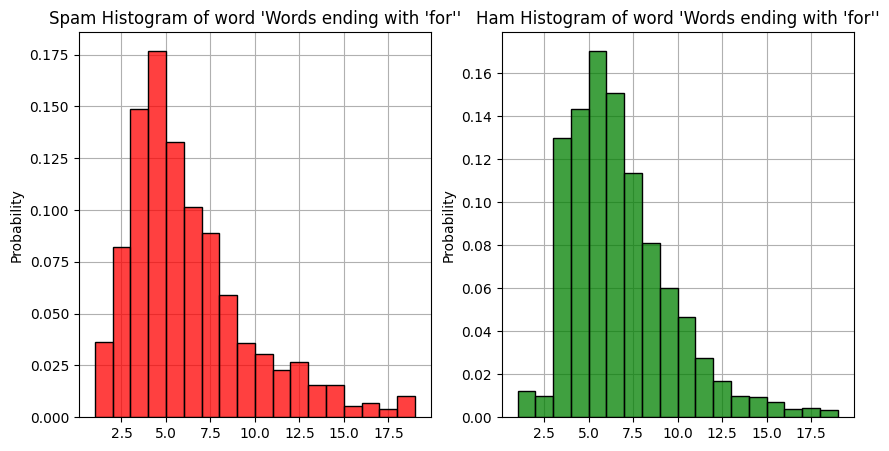

In [118]:
plt.figure(figsize=(10, 5))

word = "Words ending with 'for'"


plt.subplot(1, 2, 1)
sns.histplot(x_spam.to_numpy().sum(axis=1), color="red", stat="probability", bins=np.arange(1, 20), zorder=20)
plt.title(f"Spam Histogram of word '{word}'")
plt.xlabel("")
plt.grid("on", zorder=1)


plt.subplot(1, 2, 2)
sns.histplot(x_ham.to_numpy().sum(axis=1), color="green", stat="probability", bins=np.arange(1, 20), zorder=20)
plt.title(f"Ham Histogram of word '{word}'")
plt.xlabel("")
plt.grid("on", zorder=1)


OL, now we see, there're about 60 important words which have different distributions in to spam and ham

In [120]:
important_words = "., with, 2002, the, of, -0500, to, I, a, that, it, .>, is, +0100, .Received:, ESMTP, id, by, Linux, and, .Content-Type:, .Sender:, .Errors-To:, .X-Mailman-Version:, .Precedence:, bulk, .List-Id:, .X-Beenthere:, (Postfix), using, .Delivered-To:, or, <jm@localhost>;, -0400, IMAP, (fetchmail-5.9.0), jm@localhost, (single-drop);, (IST), you, (PDT), -0700, [127.0.0.1], SMTP, (jalapeno, in, .Content-Transfer-Encoding:, will, your, email, Microsoft, its, >, our, want, <a, .<font,".replace(" ", "").split(",")
important_words = [w for w in important_words if w]
important_words

['.',
 'with',
 '2002',
 'the',
 'of',
 '-0500',
 'to',
 'I',
 'a',
 'that',
 'it',
 '.>',
 'is',
 '+0100',
 '.Received:',
 'ESMTP',
 'id',
 'by',
 'Linux',
 'and',
 '.Content-Type:',
 '.Sender:',
 '.Errors-To:',
 '.X-Mailman-Version:',
 '.Precedence:',
 'bulk',
 '.List-Id:',
 '.X-Beenthere:',
 '(Postfix)',
 'using',
 '.Delivered-To:',
 'or',
 '<jm@localhost>;',
 '-0400',
 'IMAP',
 '(fetchmail-5.9.0)',
 'jm@localhost',
 '(single-drop);',
 '(IST)',
 'you',
 '(PDT)',
 '-0700',
 '[127.0.0.1]',
 'SMTP',
 '(jalapeno',
 'in',
 '.Content-Transfer-Encoding:',
 'will',
 'your',
 'email',
 'Microsoft',
 'its',
 '>',
 'our',
 'want',
 '<a',
 '.<font']

In [126]:
with open("data/train.pkl", "rb") as file:
    X_train = pickle.load(file)

In [133]:
counts = []
for index, row in X_train.iterrows():
    x = pd.Series(row["Message"].split(" "))
    x = x[x != ""]
    counts.append(
        ((x.str.find("<") >= 0) | (x.str.find(">") >= 0)).to_numpy().sum()
    )

In [134]:
X_train["<>_count"] = pd.Series(counts)

Status                                            Message  <>_count
973         2  From OWNER-NOLIST-SGODAILY*JM**NETNOTEINC*-COM...        32
4592        0  Return-Path: skip@pobox.com\n.Delivery-Date: S...        20
13730       0  From ilug-admin@linux.ie  Fri Jul 19 23:44:22 ...       143
3046        2  From travelincentives@aol.com  Mon Aug  6 20:0...         4
6790        0  From rpm-list-admin@freshrpms.net  Wed Jul 31 ...        32

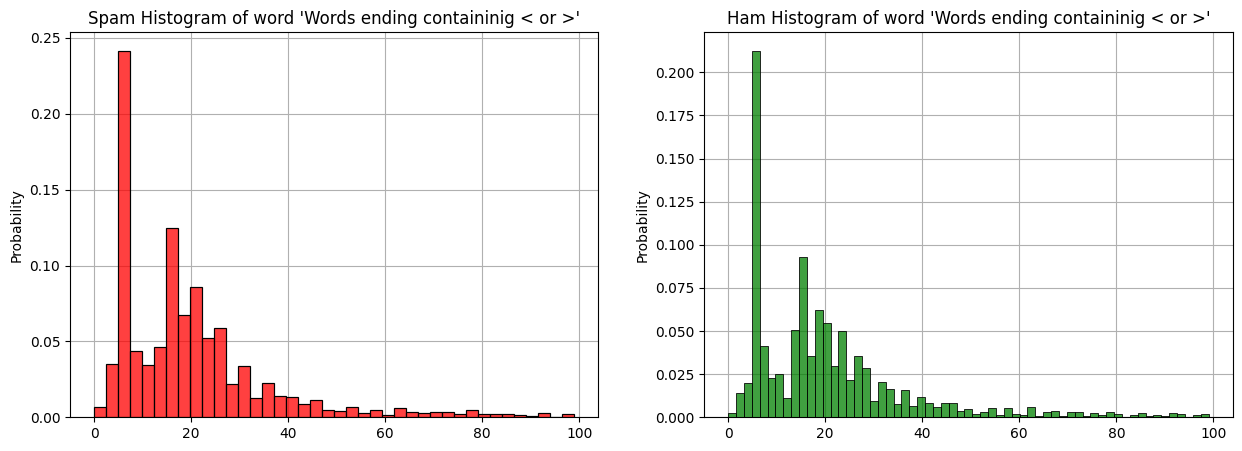

In [166]:
x_spam = X_train["<>_count"][X_train["Status"] == 2]
x_ham = X_train["<>_count"][X_train["Status"] < 2]

x_spam = x_spam[x_spam < 100]
x_ham = x_ham[x_ham < 100]

plt.figure(figsize=(15, 5))

word = "Words ending containinig < or >"


plt.subplot(1, 2, 1)
spam = sns.histplot(x_spam, color="red", stat="probability", zorder=20)
plt.title(f"Spam Histogram of word '{word}'")
plt.xlabel("")
plt.grid("on", zorder=1)


plt.subplot(1, 2, 2)
ham = sns.histplot(x_ham, color="green", stat="probability", zorder=20)
plt.title(f"Ham Histogram of word '{word}'")
plt.xlabel("")
plt.grid("on", zorder=1)
